In [1]:
import os
from essentia.standard import *
from essentia import Pool, array
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from scipy.io.wavfile import read, write
import pandas as pd
import joblib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from urllib.request import urlopen
from subprocess import run,call #allows you to spawn new processes
import re
from tempfile import NamedTemporaryFile#module creates temporary files and directories
import jinja2
import json
from IPython.display import Image


In [2]:

def get_files_in_dir(dir_name):
    '''Get all path + filenames in the dir_name directory, returns an alphabetical sorted list
    Avoid .DS_Store and notebook checkpoints
    '''
    file_names = []
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            if file == ".DS_Store" or "ipynb_checkpoints" in root:
                continue
            file_name = os.path.join(root,file)
            file_names.append(file_name)
    file_names.sort()
    return file_names

def get_Annotations_list_from_file(filename, legend, fs):
    """
    Input: annotation .txt filename
    Output: list of the annotations, checking if 2 or more have the same timestep and joining it
            dict with the value assigned to each instrument key
    """
    reader = open(filename)
    val = reader.readline().split()
    values = [x.replace('e', '') for x in val]
    annotations = [[float(values[0]),values[1], round(fs*float(values[0]))]]
    line = reader.readline()
    while line:
        val = line.split()
        values = [x.replace('e', '') for x in val]
        names = []
        # less than 60 ms difference is considered  same note/instrument
        if ( float(values[0]) - annotations[-1][0]) < 0.06 :
            if type(annotations[-1][1]) == str:
                names.append(annotations[-1][1] + '+' + values[1])
                names.append(values[1] + '+' + annotations[-1][1])
            else:
                names.append(annotations[-1][1] + '+' + values[1])
                names.append(values[1] + '+' + annotations[-1][1])
            for i in [0,1]:
                s = names[i]
                if ss in legend.keys():
                    annotations[-1][1] = s
                    break
                elif names[(i+1)%2] in legend.keys():
                    annotations[-1][1] = names[(i+1)%2]
                    break
                else:
                    annotations[-1][1] = s
                    legend[s] = len(legend) + 1
            else:
                annotations[-1][1] = s
        else:
            annotations.append([float(values[0]),values[1], round(fs*float(values[0]))])
            if annotations[-1][1] not in legend.keys():
                legend[annotations[-1][1]] = len(legend) + 1
        line = reader.readline()
    
    reader.close()
    annotations = [x for x in annotations if 'REST' not in x]
    return annotations

def SliceDrums_BeatDetection_blind(folder, audio_filename, fs):
    od_complex = OnsetDetection(method = 'complex')
    w = Windowing(type = 'hann')
    fft = FFT() # this gives us a complex FFT
    c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
    onsets = Onsets()

    x = MonoLoader(filename = folder + audio_filename, sampleRate = fs)()
    duration = float(len(x)) / fs

    x = x / np.max(np.abs(x))
    
    t = np.arange(len(x)) / float(fs)
    
    zero_array = t * 0 #used only for plotting purposes

    #Plotting
    f, axarr = plt.subplots(3,1,figsize=(130, 40))
    axarr[0].plot(t,x); axarr[0].axis('off')

    #Essentia beat tracking
    pool = Pool()
    for frame in FrameGenerator(x, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.complex', od_complex(mag, phase))


    onsets_list = onsets(array([pool['features.complex']]), [1])

    axarr[1].plot(t,zero_array);axarr[1].set_title('Onsets detected using complex spectral difference');
    axarr[1].axis('off')
    axarr[1].vlines(onsets_list, -1, 1, color = 'b')

    #Beat tracking
    beatTracker = BeatTrackerDegara()#Essentia-bug: reset function fails, so re-created
    ticks = beatTracker(x)

    axarr[2].plot(t,zero_array);axarr[2].set_title('Beats estimated');
    axarr[2].axis('off')
    axarr[2].vlines(ticks, -1, 1, color = 'r')
   
    for i, onset in enumerate(onsets_list):
        sample = int(onset * fs) - 1000
        samplename =  "{}slices/{}{}__blind.wav".format(folder, str(len(str(i))), str(i))
        if(i >=  len(onsets_list)-1):
            next_sample = len(x) 
        else:
            next_sample = int(onsets_list[i+1]*fs) - 1000
        x_seg = x[sample  :  next_sample]
        MonoWriter(filename=samplename)(x_seg)
        
    return onsets_list, duration


def get_lowLevelDescriptors(filename):
    features, features_frames = MusicExtractor(lowlevelSilentFrames='drop',
                                                  lowlevelFrameSize = 2048,
                                                  lowlevelHopSize = 1024,
                                                  lowlevelStats = ['mean', 'stdev'])(filename)

    descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
    
    return descriptors

def extract_MusicalFeatures(folder, descriptors, filename):
    file_count = 0
    segment_files = get_files_in_dir(folder)
    print(segment_files)

    with open(filename, 'w') as writer:
        
        #adding column names as the first line in csv
        line2write = ','.join(descriptors + ['instrument']).replace('lowlevel.','') + '\n'
        writer.write(line2write)
        for file in segment_files:
            if '.wav' in file:
                file_count +=1
                if file_count % 20 == 0:#print name of a file every 20 files
                    print(file_count, "files processed, current file: ",file)
                features, features_frames = MusicExtractor(lowlevelSilentFrames='drop',
                                                              lowlevelFrameSize = 2048,
                                                              lowlevelHopSize = 1024,
                                                              lowlevelStats = ['mean', 'stdev'])(file)
                selected_features = [features[descriptor] for descriptor in descriptors]
                instrument = file.split('/')[-1].split('_')[1].lower()[:-4]     #class information
                line2write = str(selected_features)[1:-1] + ',' + instrument + '\n'
                writer.write(line2write)
    print("A total of ",file_count, "files processed")

In [3]:
sr = 44100
folder = "Testing/"
annotation_file = folder + "DIWK_4bar.txt"
musical_feature_file = folder + 'DIWK_4bar.csv'

#musical_feature_file = folder + 'GoldLion.csv'

prev_files = get_files_in_dir(folder + 'slices')
for f in prev_files:
  os.remove(f)
  
audiofiles = get_files_in_dir(folder)
audiofiles = [x.split('/')[-1] for x in audiofiles if 'wav' in x]
audiofiles

['AKG314_DIWK_curt.wav', 'test.wav']

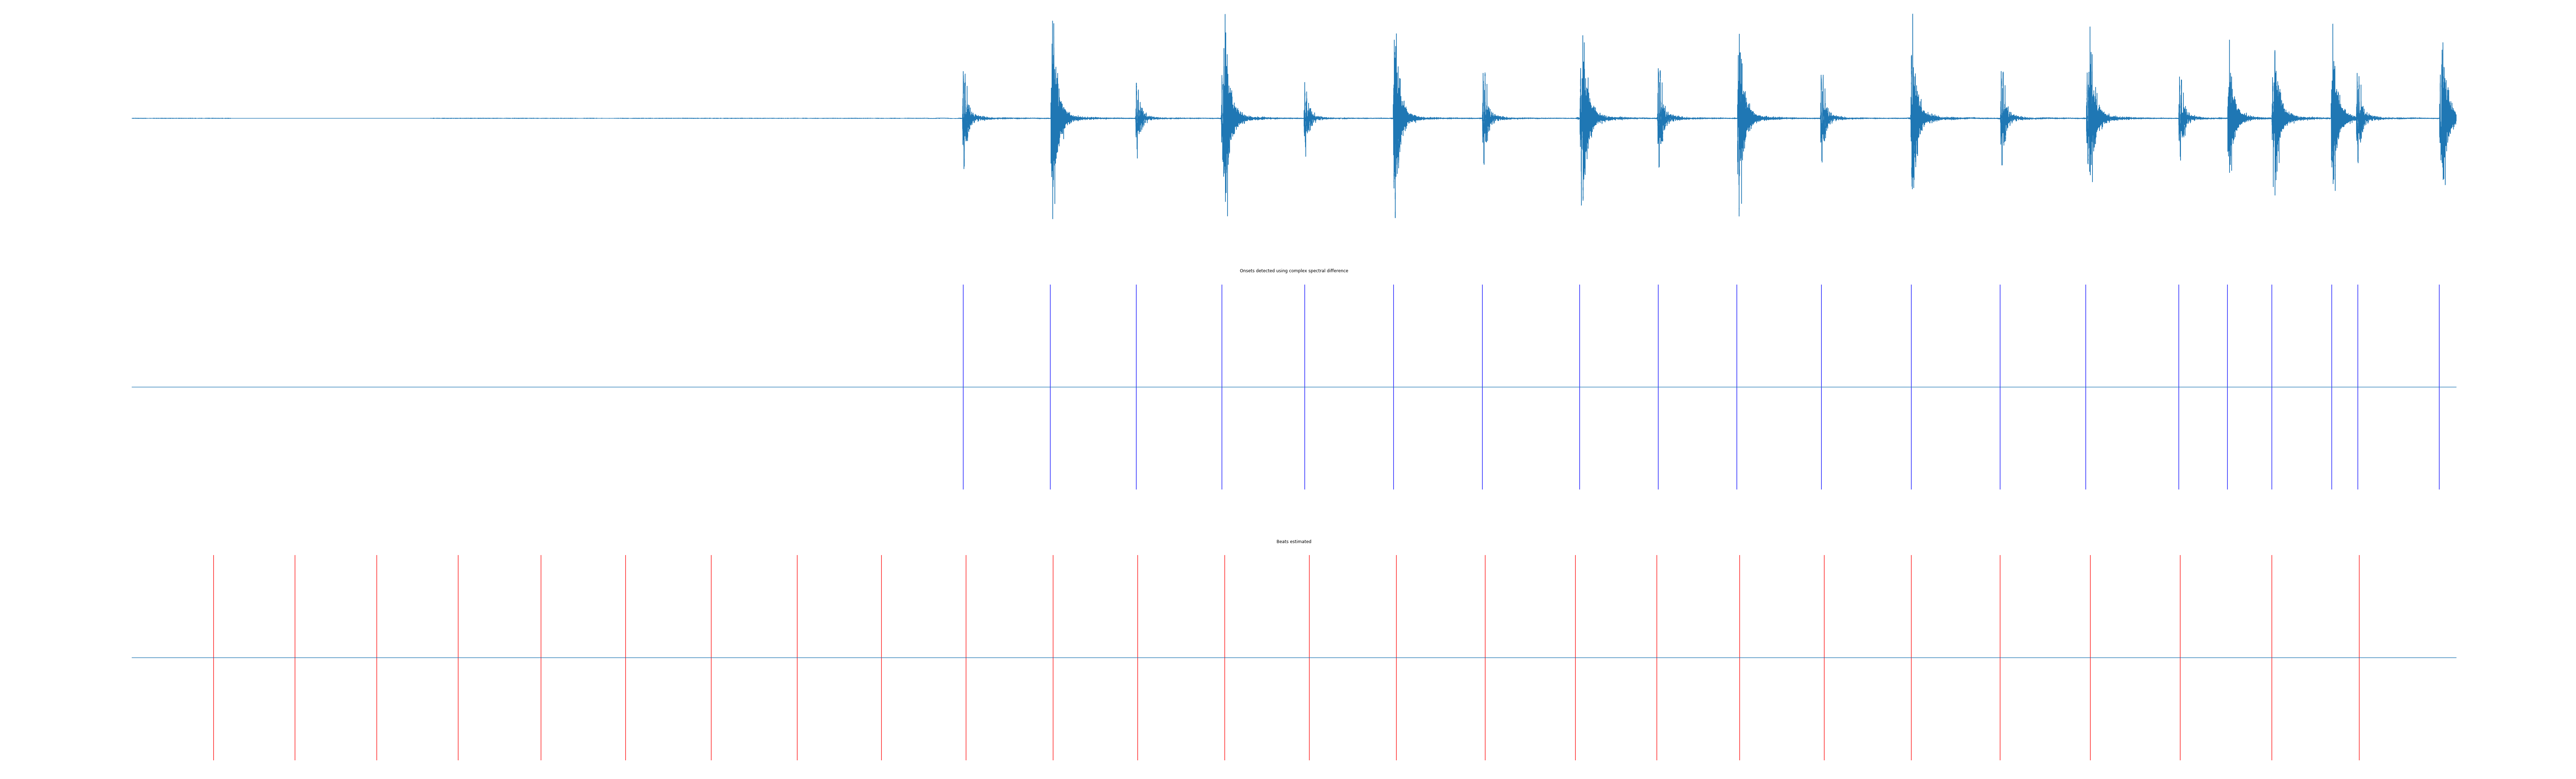

In [4]:
legend = dict()

annotations = get_Annotations_list_from_file(annotation_file, legend, sr)
annotations
    
onsets, duration = SliceDrums_BeatDetection_blind(folder, audiofiles[0], sr)

#descriptors = get_lowLevelDescriptors(folder + 'test.wav')

#file_count = extract_MusicalFeatures(folder + 'slices', descriptors, musical_feature_file)


In [5]:
def attack_rgba(attack_dev):
    '''
    Given an array of deviations, provide corresponding coloration. As the deviation gets bigger, the color will be more red.
    '''
    cdict = {'red': [(0.0, 0.0, 0.0),
                     (0.04, 0.0, 0.0),
                     (0.07, 0.99653979, 0.99653979),
                     (0.24, 0.64705882, 0.64705882),
                     (1, 0.64705882, 0.64705882)],

             'green': [(0.0, 0.40784314, 0.40784314),
                       (0.04, 0.40784314, 0.40784314),
                       (0.07, 0.89273356, 0.89273356),
                       (0.24, 0, 0),
                       (1, 0, 0)],

             'blue': [(0.0, 0.21568627, 0.21568627),
                      (0.04, 0.21568627, 0.21568627),
                      (0.07, 0.56908881, 0.56908881),
                      (0.24, 0.14901961, 0.14901961),
                      (1, 0.14901961,0.14901961)]}
    
    attacks_cm = LinearSegmentedColormap("attack_colors", cdict) #create a colormap to interpolate colors
    sm = cm.ScalarMappable(norm=plt.Normalize(0, 1, clip=True), cmap=attacks_cm) #scalar data to RGBA map
    if type(attack_dev) is not np.ndarray:
        attack_dev = np.array([attack_dev])
    abs_devs = np.abs(attack_dev)
    return sm.to_rgba(abs_devs)

#----------------------------------Plotting functions-------------------------------------------------------#
def save_bar_plot(audio,expected_attacks,left_time=0.0,right_time=None,fs=44100, w=1, h=0.1, dpi=300,
        actual_attacks=np.array([], dtype=float),color_func=attack_rgba):
    '''
    INPUT: 
    audio: targe audio to be assessed
    expected_attacks: ground trugh beats
    left: initial time of the music score
    actual_attacks: predicted onsets (predicted guitar strokes)
    
    OUTPUT: 
    '''
    # half-beat margin
    left = int(left_time * fs)
    if right_time is None: ## if the finalization time of the score not provided calculate it
        right = len(audio)
        right_time = float(right) / fs
    else:
        right = int(right_time * fs) ## if provided put it in frames instead of seconds
        
    fig = plt.figure(frameon=False)
    fig.set_size_inches(w, h)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.set_xlim(left=0, right=right-left) #set the x axis size (from the start frame to the last frame of audio)
    fig.add_axes(ax)
    
    if left < 0: #------------------------plot the audio wave 
        addon = np.zeros(-left)
        left = 0
        ax.plot(np.concatenate((addon, audio[left:right]), axis = None), lw=0.5)
    else:
        ax.plot(audio[left:right], lw=0.5)

    # filter events.
    expected_attacks = expected_attacks + left_time
    filtered_expected = expected_attacks[(expected_attacks >= left_time) & (expected_attacks < right_time)] #take the onsets that are inside your range (start - final of the score)
    filtered_actual = actual_attacks[(actual_attacks >= left_time) & (actual_attacks < right_time)] #take the gt beats that are inside your range (start - final of the score)
    ## print the GT beats above the wave and print a region colored according to the deviation of the predicted onset from the GT beat
    for x in actual_attacks: #print you predicted onset with a black line
        plt.axvline((x-left_time) * fs,0,0.25, color='k', lw=0.5)
    for x in expected_attacks:
        plt.axvline((x-left_time) * fs,0.25,0.75, color='c', lw=0.5)


    #
    for x in filtered_actual:
        i = np.searchsorted(expected_attacks, x)
        if i >= len(expected_attacks) or (0 < i and x - expected_attacks[i - 1] < expected_attacks[i] - x):
            expected_attack = expected_attacks[i - 1]
            x1 = expected_attacks[i - 1]
            x2 = x
            attack_dev = x - expected_attacks[i - 1] #calculate the deviation from the GT beat
        else:
            expected_attack = expected_attacks[i]
            x1 = x
            x2 = expected_attacks[i]
            attack_dev = x - expected_attacks[i]
        if (expected_attack in filtered_expected): #color the deviation with a region and attack_rgba fucntion
            rgbas = color_func(attack_dev)
            if rgbas[0][0] > 0.4: #----------------------------If the deviation of the tempo is pretty high, highlight it
                N=5000
                plt.axvspan(((x1 - left_time) * fs)-N,((x2 - left_time)* fs)+N,ymax=1, color='yellow',alpha=0.05) #color the tempo deviations
            
            plt.axvspan((x1 - left_time) * fs, (x2 - left_time) * fs,facecolor=rgbas[0])
    
    #Save file
    fname = NamedTemporaryFile(suffix='.eps', delete=False)
    plt.savefig(fname, dpi=dpi, format='eps')
    plt.close(fig)
    fname.close()
    !cp {fname.name} qqq.eps
    return fname.name

In [6]:
legend = dict()
annotations = get_Annotations_list_from_file(annotation_file, legend, sr)

audio = MonoLoader(filename=  folder +audiofiles[0])()

expected = [x[0] for x in annotations]
save_bar_plot(audio, np.array(expected, dtype=float) ,left_time=onsets[0],right_time=None,fs=44100, w=10, h=1, dpi=300,
        actual_attacks=np.array(onsets, dtype=float),color_func=attack_rgba)



'/var/folders/zz/c6fprw_94hzcbwg8kmcj0j6m0000gn/T/tmpy2f2s8fx.eps'

In [7]:
def score_image(template_dir, tamplate_name, normLu, eps_lambda, image_format='png'):
    '''
    INPUT:
    normLu = nlu = chroma scores #Chroma estimated
    template_name: .ly file name
    template_dir: directory where the .ly file is stored
    eps_lambda: macro that will plot the wave form using lilypond
    Create the final _assessment.png visualization using lilypond software.
    '''
    m = np.exp(normLu)
    sm = cm.ScalarMappable(
        norm=plt.Normalize(0, 1, clip=True), cmap=plt.get_cmap('RdYlGn')) #define a colormap (for deviations and notes)
    rgbas = sm.to_rgba(m)
    
    it = ColorIterator(rgbas) #Create an iterable for the lilypond macro in charge of coloring the notes
    size = SizeIterator(size_from_color(rgbas))#Create an iterable for the lilypond macro in charge of augmenting the size of miss played notes
    
    #Read the lilypond template
    latex_jinja_env = jinja2.Environment(
        variable_start_string='%{',
        variable_end_string='%}',
        trim_blocks=True,
        autoescape=False,
        loader=jinja2.FileSystemLoader(template_dir))
    template = latex_jinja_env.get_template(tamplate_name)
    
    eps_generator = TempWaveFormsGenerator(eps_lambda) #macor that will plot the wave form in lilypond
    #Assign lilypond macros to iterables created
    res = template.render({
        'next_color': lambda: it.next(),
        'current_color': lambda: it.current(),
        'next_size': lambda: size.next(),#--------------added
        'eps_waveform': eps_generator.eps
    })
    
    #Compile lilypond file with the macros
    fin = NamedTemporaryFile(suffix='.ly', delete=False)
    fin.write(res.encode('UTF8'))
    fin.close()
    #Generate using lilypond a .png image containing the visualization of the assessment
    image_format == 'png'
    suffix = 'png'
    lily_format_option = '--png'
    ext_cutter = re.compile('\.' + suffix + '$')
    fout = NamedTemporaryFile(suffix='.' + suffix,delete=False)
    fout.close()
    os.unlink(fout.name)
    !cp {fin.name} qqq.ly
    call(["lilypond", lily_format_option, "-dcrop=#t", '-o', ext_cutter.sub('', fout.name),
         "-dresolution=300", fin.name])
    
    os.unlink(fin.name)
    eps_generator.clear()  

    return fout.name

In [8]:
class ColorIterator: #Iterator that changes the color of the nodes in lilypond
    def __init__(self, rgbas):
        self.rgbas = rgbas
        self.pos = -1

    def current(self):
        return " %.3f %.3f %.3f" %\
               (self.rgbas[self.pos, 0],
                self.rgbas[self.pos, 1],
                self.rgbas[self.pos, 2])

    def __iter__(self):
        return self

    def next(self):
        self.pos += 1
        if self.pos < len(self.rgbas):
            return self.current()
        else:
            raise StopIteration

def size_from_color(rgbas):
    '''
    This functin takes the notes that are miss played and augments its size when plotting.
    '''
    sizes = []
    for rgb in rgbas:
        if rgb[0]> 0.4:
            sizes.append(5)
        else:
            sizes.append(0)
    return sizes
        
class SizeIterator:#----Iterator to change the size of miss played notes in lilypond
    def __init__(self, sizes):
        self.size = sizes
        self.pos = -1

    def current(self):
        return self.size[self.pos]

    def __iter__(self):
        return self

    def next(self):
        self.pos += 1
        if self.pos < len(self.size):
            return self.current()
        else:
            raise StopIteration

class TempWaveFormsGenerator: #macro that prints the waveform in the lilyond
    def __init__(self, gen_lambda):
        self.gen_lambda = gen_lambda
        self.all_files = []

    def eps(self, first_bar, last_bar, w = 1, h = 0.1, left_border_shift=-0.15, right_border_shift=-0.2):
        f = self.gen_lambda(first_bar, last_bar, w, h, left_border_shift, right_border_shift)
        self.all_files.append(f)
        return f

    def clear(self):
        for f in self.all_files:
            os.unlink(f)

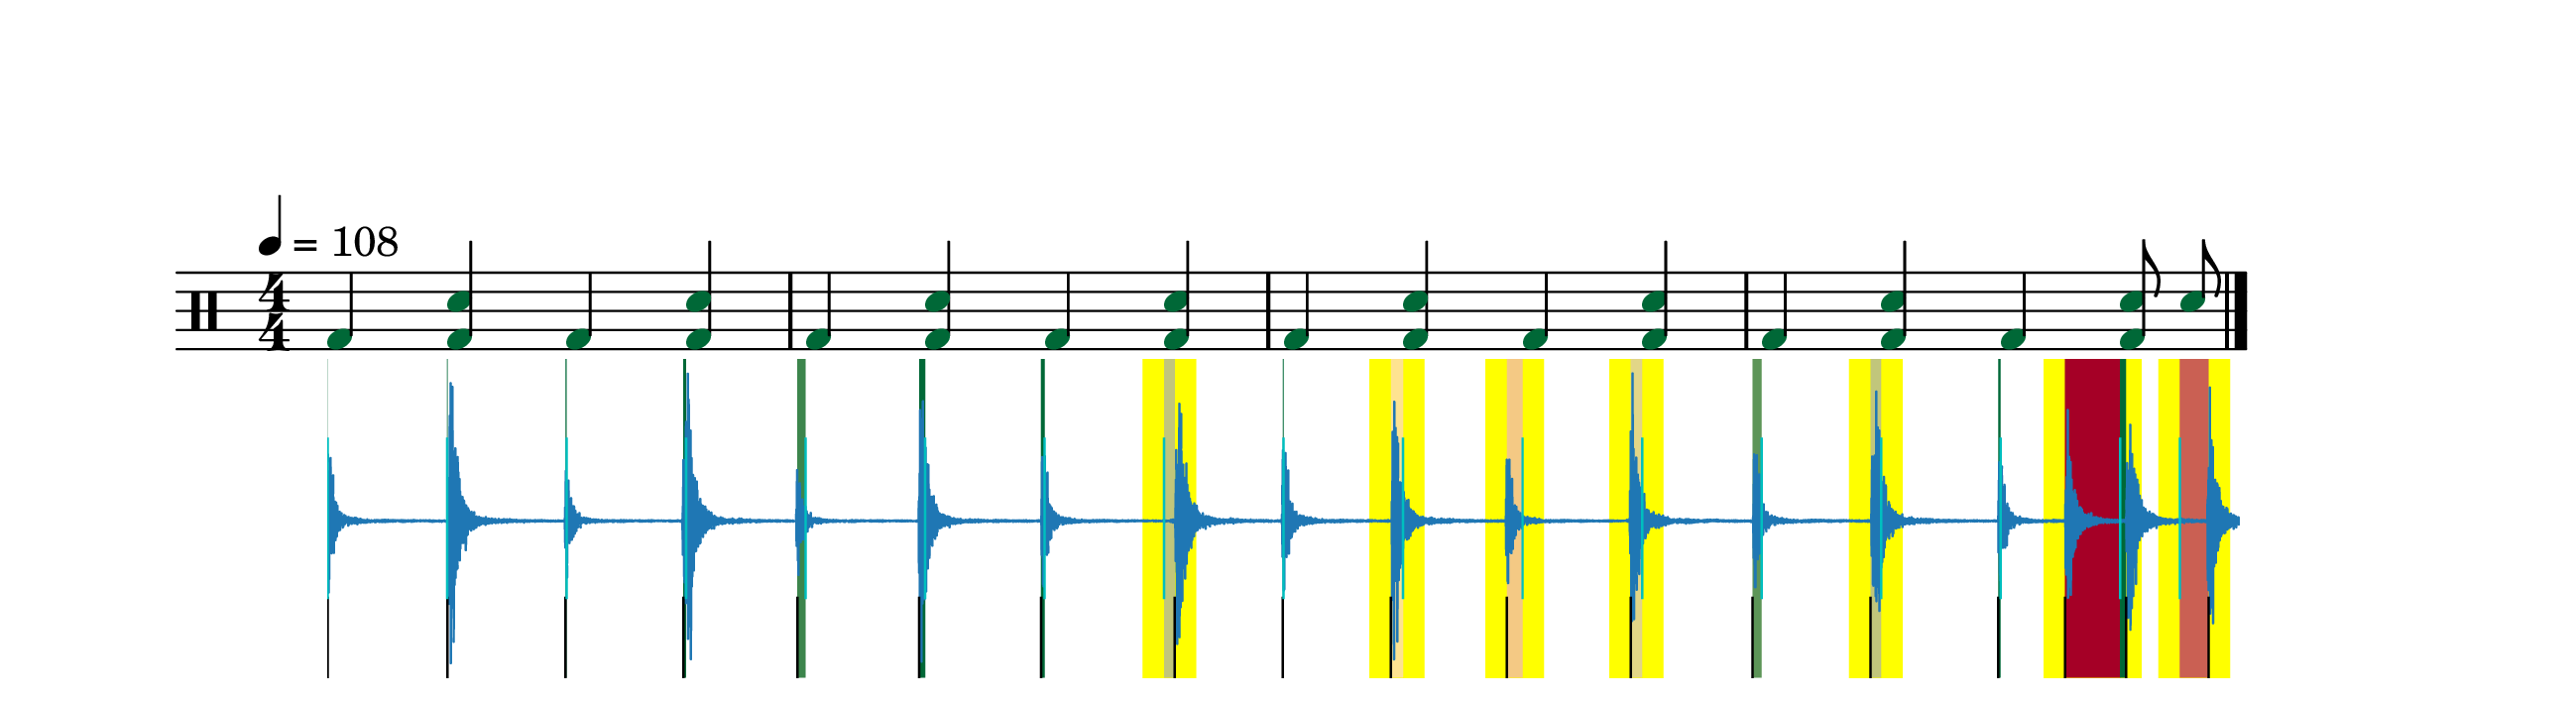

In [35]:
lilypond = folder + "DIWK_4bar.ly"

lilypond_basedir = os.path.dirname(lilypond)
lilypond_shortname = os.path.basename(lilypond)

"""
img_file_name = visualize( #visualize the assessment 
    lilypond_basedir,
    lilypond_shortname,
    timing_features['bars'],
    timing_features['events'],
    timing_features['onsets'],
    chroma_scores,
    audio,
    image_format=image_format,
    color_func=color_func)
"""

# ritht

# In general, it's wrong. It started with the annotated onset, not with detected one!
# Imagine what if fitst note is missed or incorrect?!
# But your "expected" onsets starts from zero... I don't understand it.
left_time = onsets[0]

# It's just a draft. you should use more justified approach.
# it seems, bpm is not 108 (as it written), but 85
bpm=85
right_time = left_time + 60.0/bpm*16

eps_lambda = lambda first_bar, last_bar, w, h, left_border_shift, right_border_shift:\
        save_bar_plot(audio, np.array(expected, dtype=float) ,left_time=left_time,right_time=right_time,fs=44100, w=6, h=1, dpi=150,
        actual_attacks=np.array(onsets, dtype=float),color_func=attack_rgba) #defining a macro that plot the wave form in lilypond

y_pred_ = range(30)
file_img_name = score_image(lilypond_basedir,lilypond_shortname,y_pred_,eps_lambda=eps_lambda,image_format='png') # get the lilypond file with the macros
display(Image(filename=file_img_name)) #display the result in console


In [21]:
expected

[0.0,
 0.70588,
 1.41176,
 2.11764,
 2.82352,
 3.52941,
 4.23529,
 4.94117,
 5.64705,
 6.35294,
 7.05882,
 7.7647,
 8.47058,
 9.17647,
 9.88235,
 10.5882,
 10.9411]

In [11]:
lilypond

'Testing/DIWK_4bar.ly'

In [32]:
60/0.70588

85.00028333427778